# Stress–Age Interaction Analysis
1. Split patients into younger (< 50) vs older (≥ 50)
2. Train Balanced Random Forest models separately for each age group and compare AUC, F1, and confusion matrices
3. Compute SHAP feature importance for each group and compare the importance of PIR, hsCRP, BMI, smoking, and education
4. Fit a logistic regression with interaction terms to test whether these effects differ statistically between age groups

In [1]:
# Importing packages
import numpy as np
import pandas as pd

from imblearn.ensemble import BalancedRandomForestClassifier

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, classification_report

import shap
import statsmodels.formula.api as smf

import warnings
warnings.filterwarnings('ignore')

In [2]:
# My Variables

AGE_COL          = 'age_years'
EARLY_ONSET_COL  = 'early_onset_proxy'   
DPQ_COL          = 'dpq_total'           
PIR_COL          = 'pir'                 
BMI_COL          = 'bmx_bmi'                
HSCRP_COL        = 'hscrp_mg_l_raw'
SMOKE_COL        = 'smoke_status'
EDUC_COL         = 'educ_level'

STRESS_THRESHOLD = 10

In [3]:
# Loading all the dataset again
from pathlib import Path
currentpath = Path.cwd()

# baseTablePath = Path("C:/STS/My Project/StressMetastasis/Aim1/data/analysis_base_clean.csv")
mydf = pd.read_csv(f'{currentpath.parent}/data/analysis_base_clean.csv')
print("Data loaded. Shape:", mydf.shape)
mydf.head()
mydf.columns

Data loaded. Shape: (7800, 21)


Index(['seqn', 'age_years', 'age_group', 'sex', 'race_eth', 'educ_level',
       'pir', 'mcq220', 'ever_cancer', 'dpq_total', 'dpq_cat', 'smoke_status',
       'hscrp_mg_l_raw', 'hscrp_cat', 'bmx_bmi', 'bmx_weight_kg',
       'bmx_height_cm', 'bmx_waist_cm', 'bmx_hip_cm', 'dpq_severity',
       'hscrp_flag_acute'],
      dtype='object')

# Create stress label and age groups

In [4]:
mydf[AGE_COL] = pd.to_numeric(mydf[AGE_COL], errors='coerce')

if EARLY_ONSET_COL not in mydf.columns:
    mydf[EARLY_ONSET_COL] = (mydf[AGE_COL] < 50).astype(int)

mydf[DPQ_COL] = pd.to_numeric(mydf[DPQ_COL], errors='coerce')
mydf['stress'] = (mydf[DPQ_COL] >= STRESS_THRESHOLD).astype(int)

young_mask = mydf[EARLY_ONSET_COL] == 1
older_mask = mydf[EARLY_ONSET_COL] == 0

print(f'Total rows: {len(mydf)}')
print(f'Young (<50) rows:  {young_mask.sum()}')
print(f'Older (≥50) rows: {older_mask.sum()}')

Total rows: 7800
Young (<50) rows:  3126
Older (≥50) rows: 4674


# Prepare predictors and helper for X/y

In [5]:
numeric_features = [PIR_COL, BMI_COL, HSCRP_COL]

categorical_features = [SMOKE_COL, EDUC_COL]

print('Numeric features:', numeric_features)
print('Categorical features:', categorical_features)

def make_group_xy(dataframe, mask, target_col='stress'):
    cols = numeric_features + categorical_features + [target_col]
    sub = dataframe.loc[mask, cols].dropna().copy()
    X = sub[numeric_features + categorical_features]
    y = sub[target_col].astype(int)
    return X, y

X_young, y_young = make_group_xy(mydf, young_mask, target_col='stress')
X_old,   y_old   = make_group_xy(mydf, older_mask, target_col='stress')

print('Young X shape:', X_young.shape, '| stress rate:', y_young.mean().round(3))
print('Old   X shape:', X_old.shape,   '| stress rate:', y_old.mean().round(3))

Numeric features: ['pir', 'bmx_bmi', 'hscrp_mg_l_raw']
Categorical features: ['smoke_status', 'educ_level']
Young X shape: (1831, 5) | stress rate: 0.138
Old   X shape: (2923, 5) | stress rate: 0.09


# Balanced Random Forest models (young vs older)

In [6]:
from sklearn.base import clone

preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features),
    ]
)

base_rf = BalancedRandomForestClassifier(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)

def fit_and_eval_balanced_rf(X, y, group_name='group'):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.3,
        random_state=42,
        stratify=y
    )

    model = Pipeline([
        ('preprocess', preprocess),
        ('clf', clone(base_rf)),
    ])

    model.fit(X_train, y_train)

    y_pred  = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    auc = roc_auc_score(y_test, y_proba)
    f1  = f1_score(y_test, y_pred)
    cm  = confusion_matrix(y_test, y_pred)

    print(f'\n=== {group_name} Balanced RF ===')
    print('AUC:', round(auc, 3))
    print('F1 :', round(f1, 3))
    print('Confusion matrix:\n', cm)
    print('\nClassification report:\n', classification_report(y_test, y_pred))

    return model, {'AUC': auc, 'F1': f1, 'cm': cm, 'y_test': y_test, 'y_pred': y_pred}

model_young, metrics_young = fit_and_eval_balanced_rf(X_young, y_young, group_name='Young (<50)')
model_old,   metrics_old   = fit_and_eval_balanced_rf(X_old,   y_old,   group_name='Older (≥50)')


=== Young (<50) Balanced RF ===
AUC: 0.581
F1 : 0.261
Confusion matrix:
 [[350 124]
 [ 46  30]]

Classification report:
               precision    recall  f1-score   support

           0       0.88      0.74      0.80       474
           1       0.19      0.39      0.26        76

    accuracy                           0.69       550
   macro avg       0.54      0.57      0.53       550
weighted avg       0.79      0.69      0.73       550


=== Older (≥50) Balanced RF ===
AUC: 0.607
F1 : 0.174
Confusion matrix:
 [[614 184]
 [ 54  25]]

Classification report:
               precision    recall  f1-score   support

           0       0.92      0.77      0.84       798
           1       0.12      0.32      0.17        79

    accuracy                           0.73       877
   macro avg       0.52      0.54      0.51       877
weighted avg       0.85      0.73      0.78       877



# SHAP feature importance

In [7]:
def get_transformed_and_names(model, X):
    pre = model.named_steps['preprocess']
    X_trans = pre.transform(X)
    feature_names = pre.get_feature_names_out()
    return X_trans, feature_names

# Recreate train splits so we can compute SHAP on training data
Xy_train, Xy_test, yy_train, yy_test = train_test_split(
    X_young, y_young, test_size=0.3, random_state=42, stratify=y_young
)
Xo_train, Xo_test, yo_train, yo_test = train_test_split(
    X_old, y_old, test_size=0.3, random_state=42, stratify=y_old
)

Xy_train_trans, feat_names = get_transformed_and_names(model_young, Xy_train)
Xo_train_trans, _          = get_transformed_and_names(model_old,   Xo_train)

rf_young = model_young.named_steps['clf']
rf_old   = model_old.named_steps['clf']

explainer_young = shap.TreeExplainer(rf_young)
explainer_old   = shap.TreeExplainer(rf_old)

shap_vals_young = explainer_young.shap_values(Xy_train_trans)
shap_vals_old   = explainer_old.shap_values(Xo_train_trans)

In [8]:
def get_class1_shap_array(shap_values):
    if isinstance(shap_values, list):
        return np.array(shap_values[1])

    sv = np.array(shap_values)

    if sv.ndim == 2:
        return sv

    if sv.ndim == 3:
        return sv[:, :, 1]

    raise ValueError(f'Unexpected SHAP shape: {sv.shape}')

sv_y = get_class1_shap_array(shap_vals_young)
sv_o = get_class1_shap_array(shap_vals_old)

print('sv_y shape (class 1):', sv_y.shape)
print('sv_o shape (class 1):', sv_o.shape)
print('Xy_train_trans shape:', Xy_train_trans.shape)
print('Xo_train_trans shape:', Xo_train_trans.shape)
print('Number of feature names:', len(feat_names))

sv_y shape (class 1): (1281, 9)
sv_o shape (class 1): (2046, 9)
Xy_train_trans shape: (1281, 9)
Xo_train_trans shape: (2046, 9)
Number of feature names: 9


# Align SHAP columns with transformed features

In [9]:
def align_shap_with_features(sv, X_trans, feat_names):
    # If SHAP has one extra column , drop the last column
    if sv.shape[1] == X_trans.shape[1] + 1:
        sv = sv[:, :-1]

    assert sv.shape[1] == X_trans.shape[1] == len(feat_names), (
        f'Mismatch: SHAP cols={sv.shape[1]}, X cols={X_trans.shape[1]}, feat_names={len(feat_names)}'
    )
    return sv

sv_y = align_shap_with_features(sv_y, Xy_train_trans, feat_names)
sv_o = align_shap_with_features(sv_o, Xo_train_trans, feat_names)

print('Aligned sv_y shape:', sv_y.shape)
print('Aligned sv_o shape:', sv_o.shape)

Aligned sv_y shape: (1281, 9)
Aligned sv_o shape: (2046, 9)


# SHAP summary plots

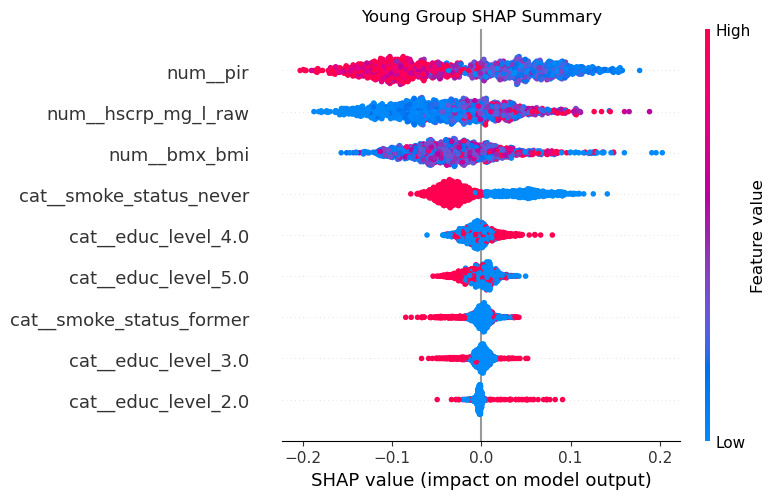

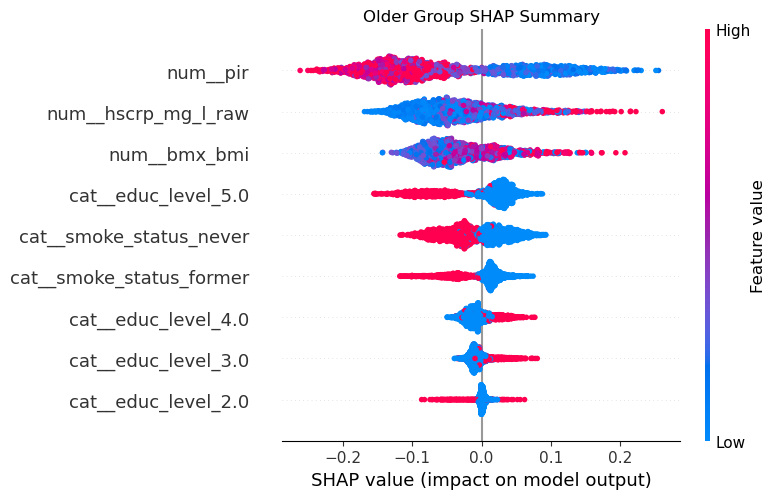

In [10]:
import matplotlib.pyplot as plt

# Young group SHAP summary
shap.summary_plot(
    sv_y,
    Xy_train_trans,
    feature_names=feat_names,
    show=False
)
plt.title("Young Group SHAP Summary")
plt.tight_layout()
plt.show()

# Older group SHAP summary
shap.summary_plot(
    sv_o,
    Xo_train_trans,
    feature_names=feat_names,
    show=False
)
plt.title("Older Group SHAP Summary")
plt.tight_layout()
plt.show()

# SHAP comparison

In [11]:
mean_abs_shap_y = pd.Series(np.abs(sv_y).mean(axis=0), index=feat_names)
mean_abs_shap_o = pd.Series(np.abs(sv_o).mean(axis=0), index=feat_names)

shap_compare = pd.DataFrame({
    'Young_mean_|SHAP|': mean_abs_shap_y,
    'Old_mean_|SHAP|':   mean_abs_shap_o,
}).sort_values('Young_mean_|SHAP|', ascending=False)

shap_compare.head(20)

,Young_mean_|SHAP|,Old_mean_|SHAP|
num__pir,0.074244,0.105795
num__hscrp_mg_l_raw,0.058284,0.059525
num__bmx_bmi,0.047181,0.050719
cat__smoke_status_never,0.038912,0.035940
cat__educ_level_4.0,0.012870,0.016620
cat__educ_level_5.0,0.012144,0.043649
cat__smoke_status_former,0.009438,0.025916
cat__educ_level_3.0,0.007667,0.012572
cat__educ_level_2.0,0.004349,0.004878


# Logistic regression with interaction terms

In [12]:
# Build analysis dataframe for regression
cols_needed = [
    'stress', EARLY_ONSET_COL,
    PIR_COL, BMI_COL, HSCRP_COL,
    SMOKE_COL, EDUC_COL,
]

d = mydf[cols_needed].dropna().copy()
print('Rows used for logistic regression:', len(d))

# Log-transform hsCRP for regression stability
d[HSCRP_COL] = pd.to_numeric(d[HSCRP_COL], errors='coerce')
d['log_hscrp'] = np.log1p(d[HSCRP_COL])
HSCRP_TERM = 'log_hscrp'

d[['stress', EARLY_ONSET_COL, PIR_COL, BMI_COL, HSCRP_TERM, SMOKE_COL, EDUC_COL]].head()

Rows used for logistic regression: 4754


,stress,early_onset_proxy,pir,bmx_bmi,log_hscrp,smoke_status,educ_level
0,0,0,5.00,33.5,1.108563,former,5.0
1,0,1,1.41,29.7,1.890095,never,3.0
2,0,1,1.33,30.2,0.717840,former,4.0
4,0,1,2.16,46.0,2.501436,never,3.0
5,1,1,0.93,38.9,1.515127,current,3.0


# Fit logistic regression model

In [13]:
formula = (
    f'stress ~ {EARLY_ONSET_COL} * ('
    f'{PIR_COL} + {BMI_COL} + {HSCRP_TERM} + C({SMOKE_COL}) + C({EDUC_COL})'
    f')'
)

print('Logistic regression formula:\n', formula)

logit_model = smf.logit(formula, data=d).fit(disp=False)
logit_model.summary()

Logistic regression formula:
 stress ~ early_onset_proxy * (pir + bmx_bmi + log_hscrp + C(smoke_status) + C(educ_level))


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 stress   No. Observations:                 4754
Model:                          Logit   Df Residuals:                     4734
Method:                           MLE   Df Model:                           19
Date:                Mon, 24 Nov 2025   Pseudo R-squ.:                 0.05794
Time:                        22:27:39   Log-Likelihood:                -1536.2
converged:                       True   LL-Null:                       -1630.7
Covariance Type:            nonrobust   LLR p-value:                 5.268e-30
===============================================================================================================
                                                  coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
Intercept                                      -2.0534      0.397     -5.174      0.000      -2.831      -1.275
C(smoke_status)[T.former]                      -0.6941      0.184     -3.763      0.000      -1.056      -0.333
C(smoke_status)[T.never]                       -0.6674      0.174     -3.828      0.000      -1.009      -0.326
C(educ_level)[T.2.0]                            0.0841      0.339      0.248      0.804      -0.580       0.748
C(educ_level)[T.3.0]                            0.1846      0.307      0.600      0.548      -0.418       0.787
C(educ_level)[T.4.0]                            0.3437      0.303      1.135      0.256      -0.250       0.937
C(educ_level)[T.5.0]                           -0.0982      0.330     -0.298      0.766      -0.745       0.548
early_onset_proxy                               0.3679      0.653      0.563      0.573      -0.912       1.648
early_onset_proxy:C(smoke_status)[T.former]     0.3403      0.288      1.180      0.238      -0.225       0.906
early_onset_proxy:C(smoke_status)[T.never]      0.1544      0.252      0.613      0.540      -0.340       0.648
early_onset_proxy:C(educ_level)[T.2.0]          0.1492      0.617      0.242      0.809      -1.061       1.359
early_onset_proxy:C(educ_level)[T.3.0]          0.0446      0.562      0.079      0.937      -1.057       1.146
early_onset_proxy:C(educ_level)[T.4.0]          0.1973      0.551      0.358      0.720      -0.883       1.278
early_onset_proxy:C(educ_level)[T.5.0]          0.4968      0.579      0.858      0.391      -0.638       1.631
pir                                            -0.2483      0.049     -5.046      0.000      -0.345      -0.152
bmx_bmi                                         0.0206      0.010      2.057      0.040       0.001       0.040
log_hscrp                                       0.1463      0.093      1.575      0.115      -0.036       0.328
early_onset_proxy:pir                          -0.0087      0.071     -0.122      0.903      -0.148       0.131
early_onset_proxy:bmx_bmi                      -0.0103      0.014     -0.736      0.462      -0.038       0.017
early_onset_proxy:log_hscrp                     0.0207      0.135      0.154      0.878      -0.243       0.284
===============================================================================================================
"""

# Extract and interpret interaction terms

In [14]:
params = logit_model.params
pvals  = logit_model.pvalues

interaction_mask = params.index.str.contains(f'{EARLY_ONSET_COL}:')

interaction_results = pd.DataFrame({
    'coef': params[interaction_mask],
    'pval': pvals[interaction_mask],
})
interaction_results['OR'] = np.exp(interaction_results['coef'])

interaction_results.sort_values('pval')

,coef,pval,OR
early_onset_proxy:C(smoke_status)[T.former],0.340340,0.237956,1.405426
early_onset_proxy:C(educ_level)[T.5.0],0.496767,0.390795,1.643399
early_onset_proxy:bmx_bmi,-0.010339,0.461812,0.989715
early_onset_proxy:C(smoke_status)[T.never],0.154383,0.540159,1.166937
early_onset_proxy:C(educ_level)[T.4.0],0.197348,0.720306,1.218168
early_onset_proxy:C(educ_level)[T.2.0],0.149172,0.809034,1.160872
early_onset_proxy:log_hscrp,0.020658,0.877988,1.020873
early_onset_proxy:pir,-0.008661,0.903158,0.991376
early_onset_proxy:C(educ_level)[T.3.0],0.044555,0.936787,1.045563


Younger cancer patients have clearer, more consistent stress patterns that machine-learning models can learn more easily. Older patients show higher SHAP variability and more complex stress determinants.